In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [4]:
def get_random_h():
    z = torch.randn((50, 16))     
    return z

In [5]:
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [6]:
fixed_data, fixed_cl = next(iter(test_loader))
fixed_h = get_random_h()
fixed_z_label = torch.tensor(list(range(10))).repeat((5))

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [10]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(torch.randn((batch_size, self.latent_size)))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [11]:
models = {
    'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [13]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [14]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            with torch.no_grad():
                print ("Model {}:".format(k))
                ae_data = models[k].forward(fixed_data).data.numpy()
                fixed_gen = models[k].decode(fixed_h).data.numpy()
                random_gen = models[k].decode(get_random_h()).data.numpy()
                plot_mnist(ae_data, (5, 10))
                plot_mnist(fixed_gen, (5, 10)) 
                plot_mnist(random_gen, (5, 10)) 

                encoded = model.encode(fixed_data[:10])
                enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
                plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr: AE:1.7109 D:0.7015 Adam Discr+bn+dp: AE:1.9107 D:0.6917
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr: AE:2.2299 D:0.1995 Adam Discr+bn+dp: AE:2.7812 D:0.1199
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr: AE:2.6990 D:0.0904 Adam Discr+bn+dp: AE:3.1730 D:0.0974
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr: AE:4.5097 D:0.0292 Adam Discr+bn+dp: AE:4.2099 D:0.0280
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr: AE:4.6509 D:0.0110 Adam Discr+bn+dp: AE:4.7817 D:0.0108
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr: AE:5.9286 D:0.0046 Adam Discr+bn+dp: AE:5.2565 D:0.0061
Model Adam Discr:


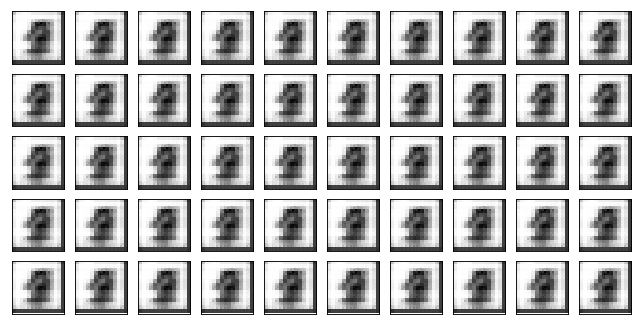

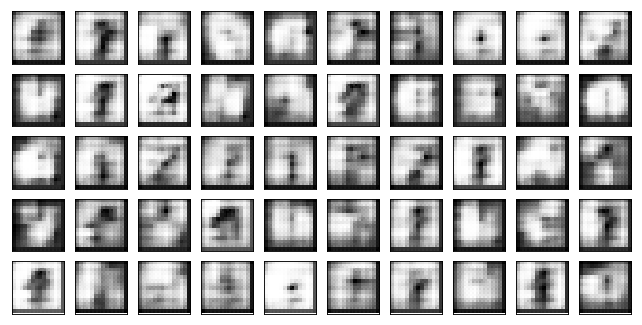

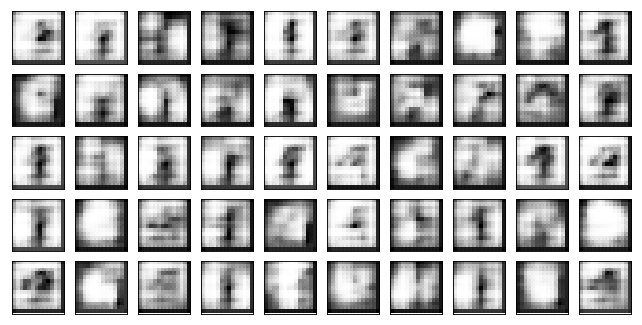

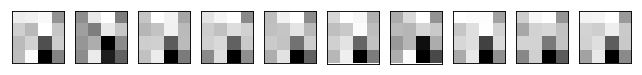

Model Adam Discr+bn+dp:


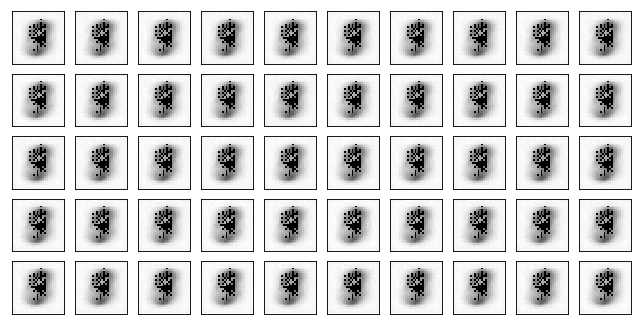

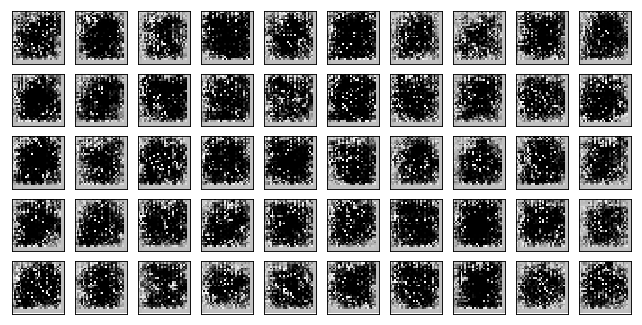

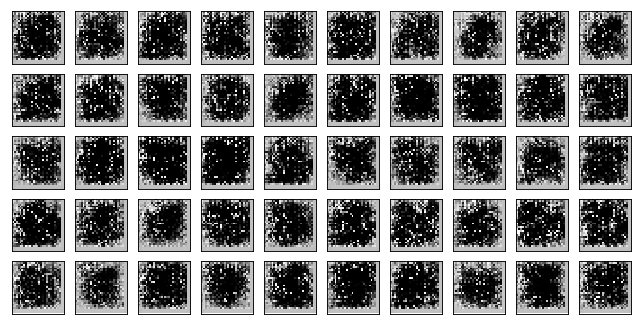

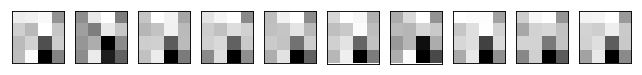

Test losses: 
Adam Discr: 1.94771159 / 28.38880348 / 0.03999768 
Adam Discr+bn+dp: 2.72830534 / 23.77193451 / 0.02661792 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr: AE:5.9260 D:0.0058 Adam Discr+bn+dp: AE:5.3028 D:0.0090
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr: AE:6.2949 D:0.0125 Adam Discr+bn+dp: AE:5.7252 D:0.0041
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr: AE:6.8410 D:0.0011 Adam Discr+bn+dp: AE:6.0428 D:0.0042
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr: AE:6.8745 D:0.0023 Adam Discr+bn+dp: AE:6.3652 D:0.0185
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr: AE:6.9312 D:0.0011 Adam Discr+bn+dp: AE:6.7518 D:0.0012
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr: AE:7.1524 D:0.0008 Adam Discr+bn+dp: AE:5.8250 D:0.0095
Model Adam Discr:


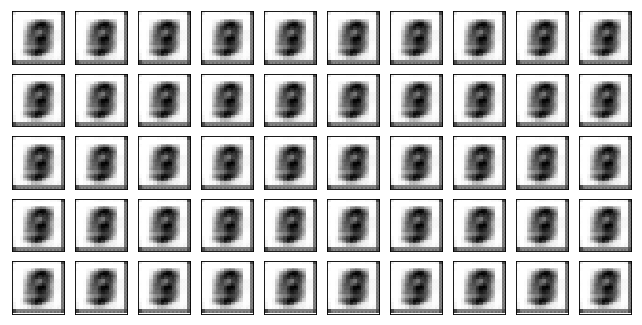

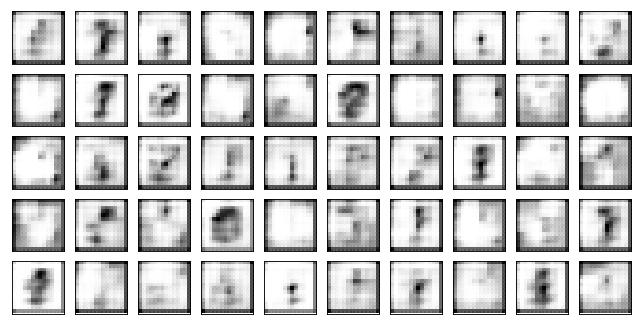

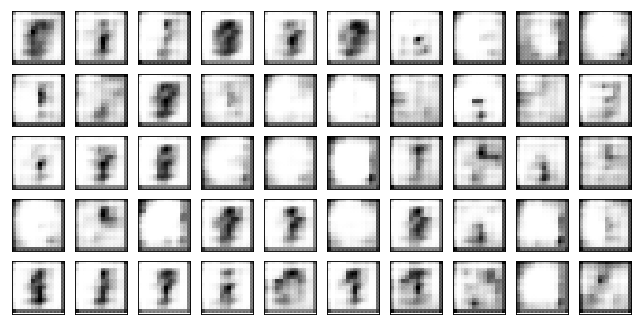

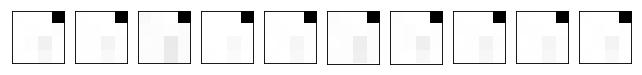

Model Adam Discr+bn+dp:


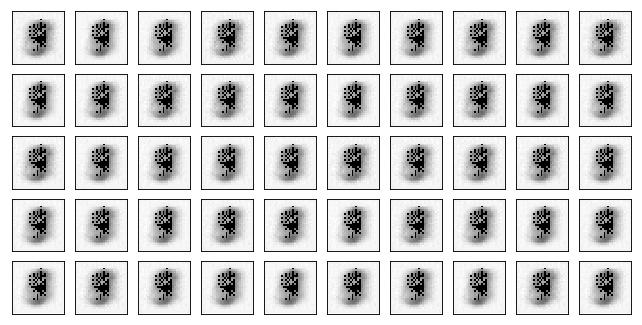

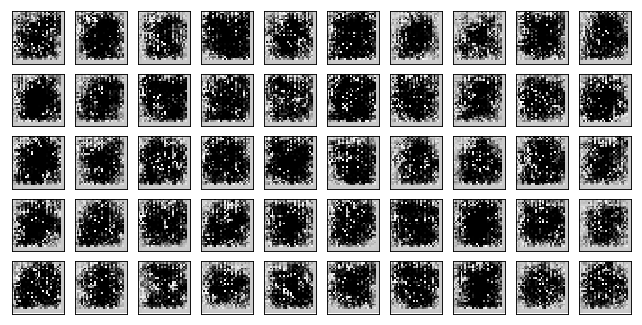

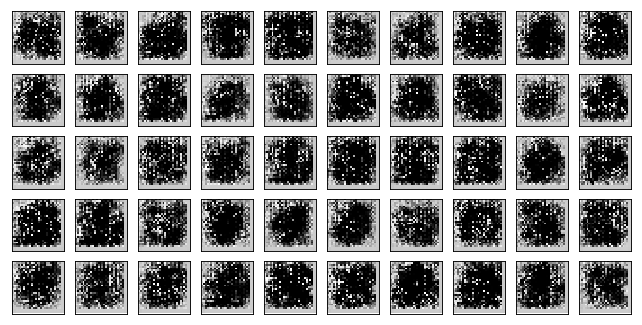

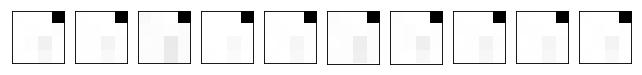

Test losses: 
Adam Discr: 1.58062375 / 36.58494568 / 0.00442389 
Adam Discr+bn+dp: 2.45350385 / 26.50033379 / 0.01561201 

Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr: AE:7.5330 D:0.0006 Adam Discr+bn+dp: AE:6.0758 D:0.0044
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr: AE:7.7387 D:0.0008 Adam Discr+bn+dp: AE:7.0424 D:0.0112
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr: AE:7.8688 D:0.0005 Adam Discr+bn+dp: AE:6.6414 D:0.0020
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam Discr: AE:5.2694 D:0.0362 Adam Discr+bn+dp: AE:7.4822 D:0.0012
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam Discr: AE:6.2264 D:0.0025 Adam Discr+bn+dp: AE:7.1937 D:0.0015
Train Epoch: 3 [50000/50000 (100%)]	Losses Adam Discr: AE:6.2028 D:0.0019 Adam Discr+bn+dp: AE:7.6707 D:0.0014
Model Adam Discr:


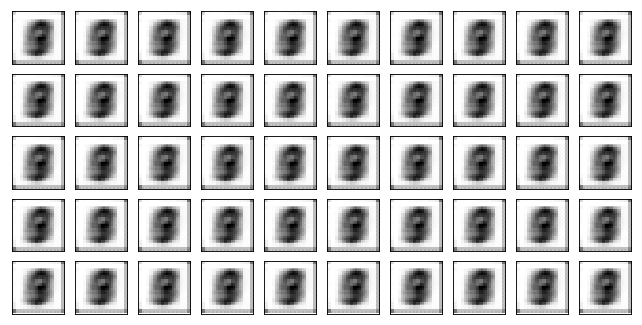

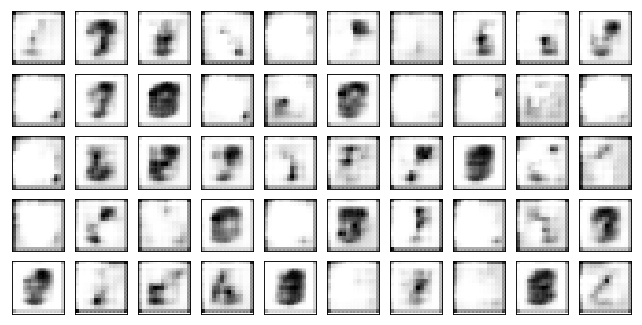

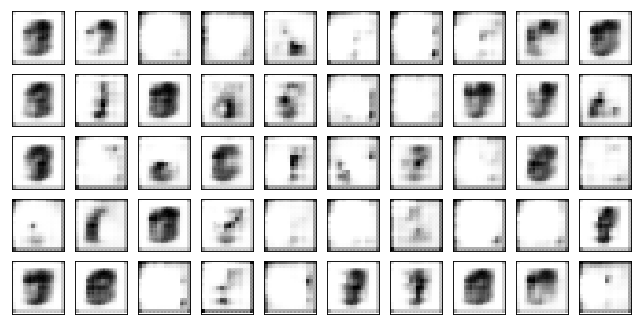

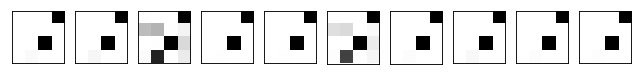

Model Adam Discr+bn+dp:


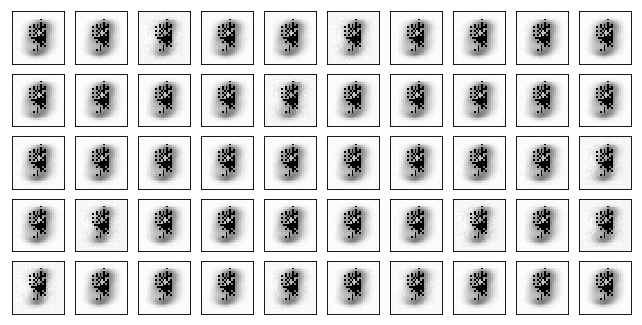

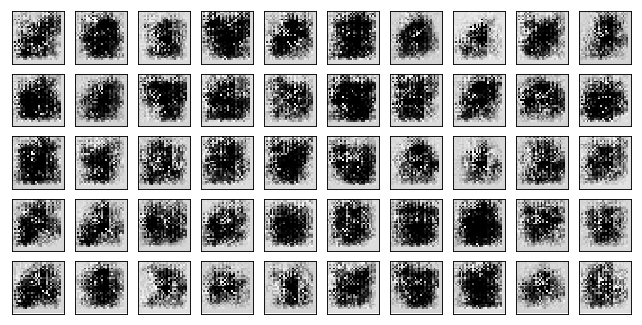

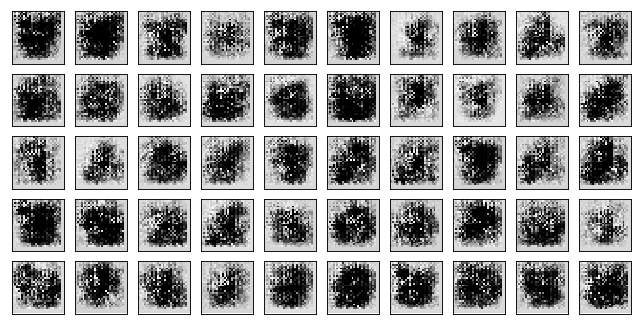

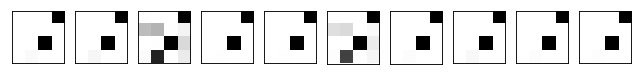

Test losses: 
Adam Discr: 1.42892694 / 31.51259995 / 0.00799731 
Adam Discr+bn+dp: 2.24305677 / 35.74501038 / 0.00412456 

Train Epoch: 4 [0/50000 (0%)]	Losses Adam Discr: AE:6.5217 D:0.0015 Adam Discr+bn+dp: AE:7.3644 D:0.0019
Train Epoch: 4 [10000/50000 (20%)]	Losses Adam Discr: AE:6.8823 D:0.0010 Adam Discr+bn+dp: AE:7.4965 D:0.0009
Train Epoch: 4 [20000/50000 (40%)]	Losses Adam Discr: AE:6.6858 D:0.0014 Adam Discr+bn+dp: AE:7.9227 D:0.0008
Train Epoch: 4 [30000/50000 (60%)]	Losses Adam Discr: AE:7.2934 D:0.0480 Adam Discr+bn+dp: AE:7.9863 D:0.0014
Train Epoch: 4 [40000/50000 (80%)]	Losses Adam Discr: AE:7.5004 D:0.0006 Adam Discr+bn+dp: AE:8.1063 D:0.0008
Train Epoch: 4 [50000/50000 (100%)]	Losses Adam Discr: AE:7.5941 D:0.0006 Adam Discr+bn+dp: AE:7.7445 D:0.0024
Model Adam Discr:


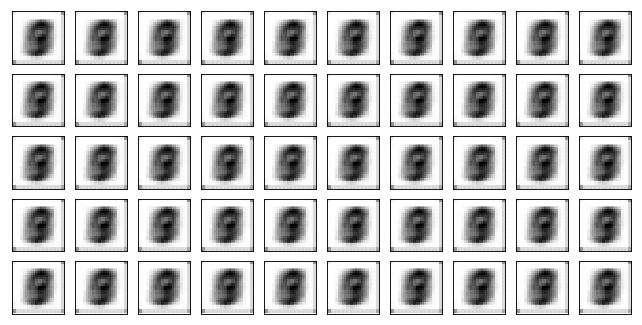

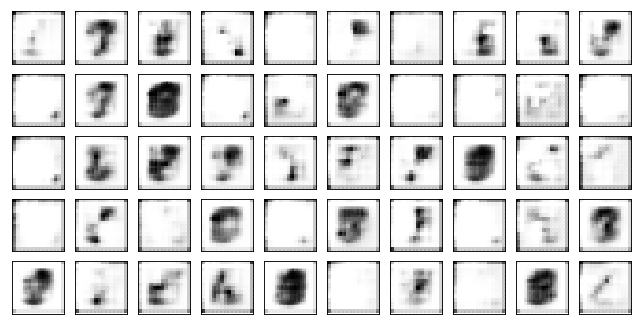

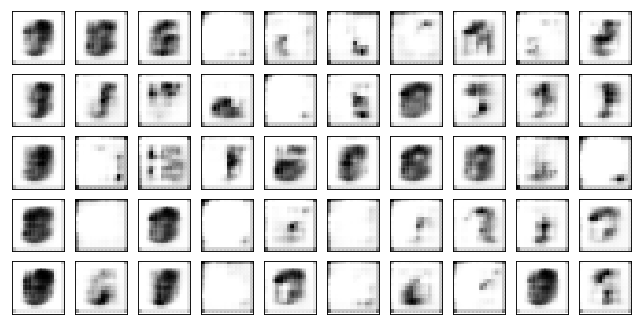

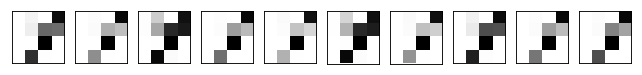

Model Adam Discr+bn+dp:


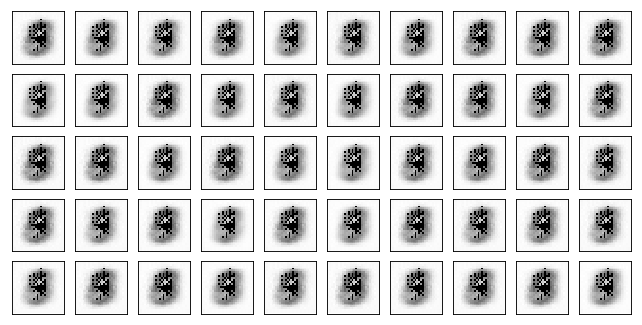

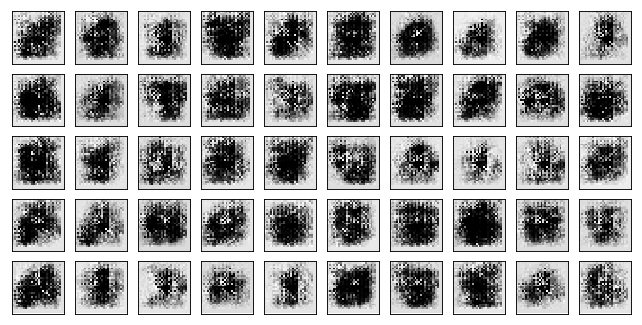

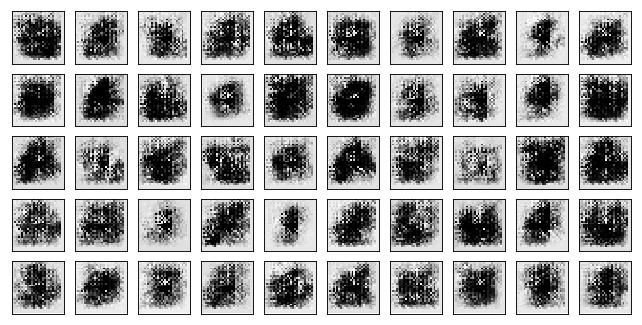

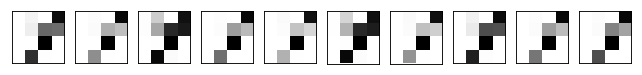

Test losses: 
Adam Discr: 1.38011730 / 38.14205933 / 0.00221384 
Adam Discr+bn+dp: 2.22253513 / 42.03026199 / 0.00304939 

Train Epoch: 5 [0/50000 (0%)]	Losses Adam Discr: AE:7.6255 D:0.0005 Adam Discr+bn+dp: AE:8.0054 D:0.0213
Train Epoch: 5 [10000/50000 (20%)]	Losses Adam Discr: AE:8.0183 D:0.0006 Adam Discr+bn+dp: AE:7.2334 D:0.0018
Train Epoch: 5 [20000/50000 (40%)]	Losses Adam Discr: AE:8.0010 D:0.0003 Adam Discr+bn+dp: AE:7.2517 D:0.0025
Train Epoch: 5 [30000/50000 (60%)]	Losses Adam Discr: AE:7.0798 D:0.0009 Adam Discr+bn+dp: AE:7.2138 D:0.0016
Train Epoch: 5 [40000/50000 (80%)]	Losses Adam Discr: AE:7.6142 D:0.0007 Adam Discr+bn+dp: AE:8.2362 D:0.0219
Train Epoch: 5 [50000/50000 (100%)]	Losses Adam Discr: AE:7.6978 D:0.0018 Adam Discr+bn+dp: AE:8.6278 D:0.0007
Model Adam Discr:


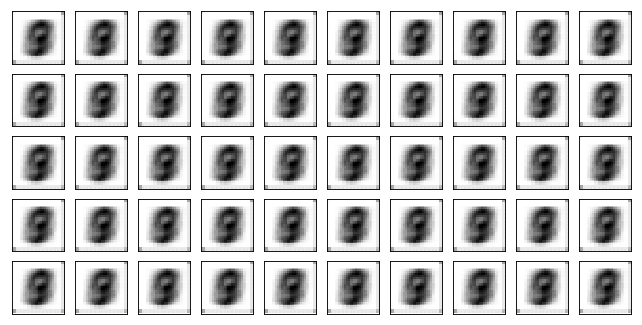

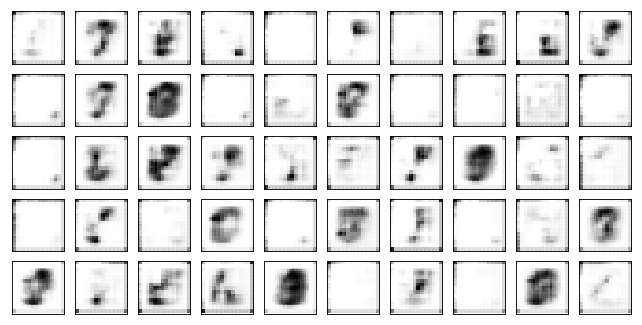

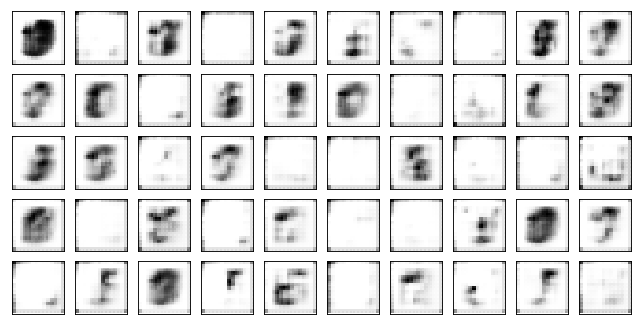

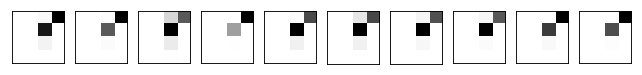

Model Adam Discr+bn+dp:


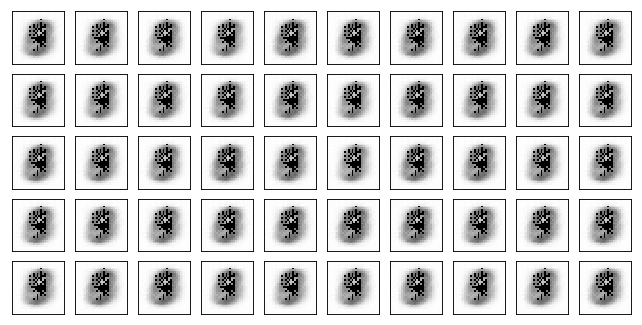

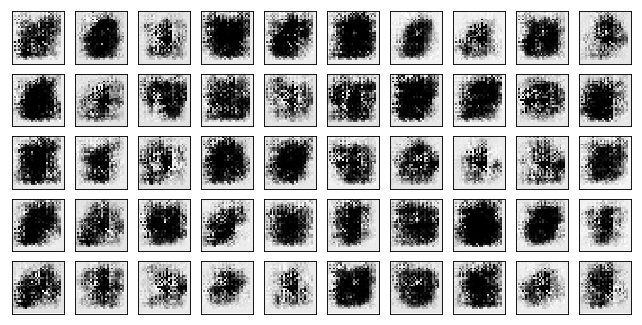

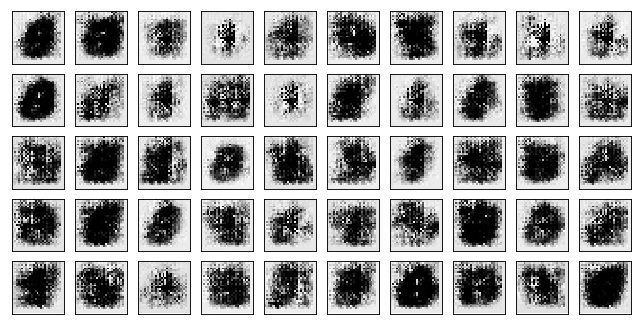

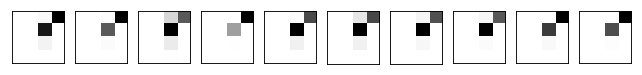

Test losses: 
Adam Discr: 1.36273742 / 37.80768204 / 0.00486494 
Adam Discr+bn+dp: 2.14342403 / 49.59104919 / 0.00240010 

Train Epoch: 6 [0/50000 (0%)]	Losses Adam Discr: AE:7.9003 D:0.0010 Adam Discr+bn+dp: AE:8.8347 D:0.0029
Train Epoch: 6 [10000/50000 (20%)]	Losses Adam Discr: AE:8.4313 D:0.0004 Adam Discr+bn+dp: AE:8.4754 D:0.0035
Train Epoch: 6 [20000/50000 (40%)]	Losses Adam Discr: AE:9.0809 D:0.0003 Adam Discr+bn+dp: AE:7.1882 D:0.0032
Train Epoch: 6 [30000/50000 (60%)]	Losses Adam Discr: AE:8.8779 D:0.0005 Adam Discr+bn+dp: AE:8.3223 D:0.0008
Train Epoch: 6 [40000/50000 (80%)]	Losses Adam Discr: AE:7.9167 D:0.0056 Adam Discr+bn+dp: AE:9.2491 D:0.0004
Train Epoch: 6 [50000/50000 (100%)]	Losses Adam Discr: AE:8.6645 D:0.0003 Adam Discr+bn+dp: AE:8.2015 D:0.0015
Model Adam Discr:


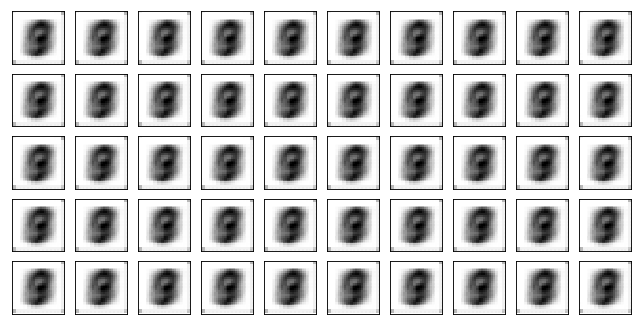

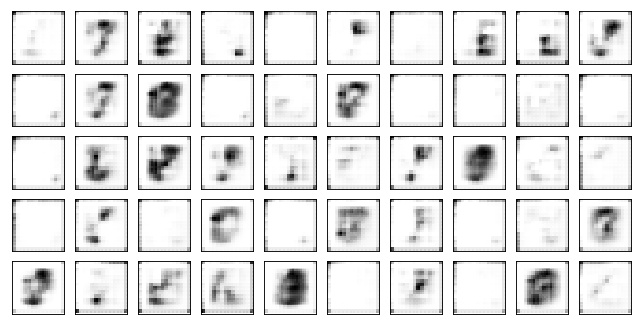

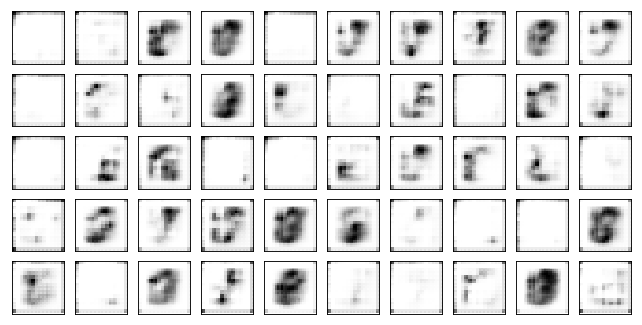

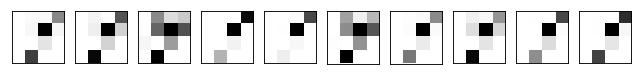

Model Adam Discr+bn+dp:


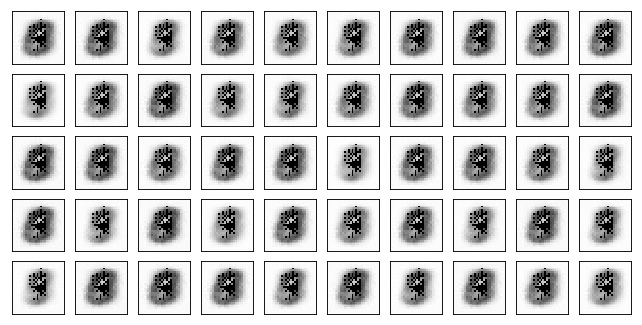

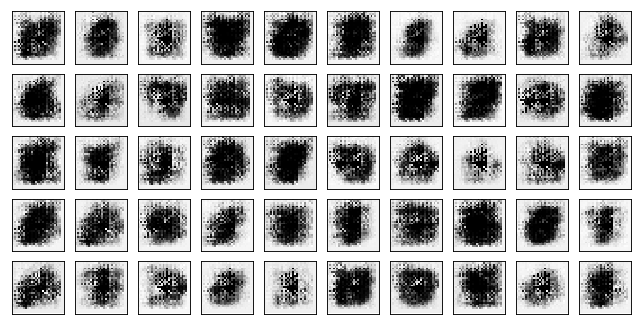

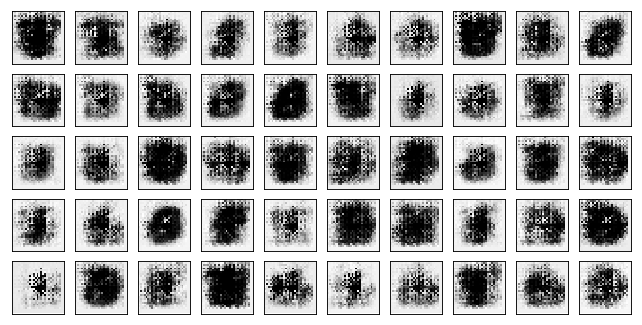

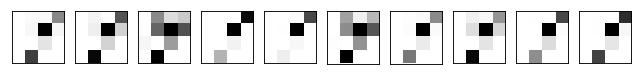

Test losses: 
Adam Discr: 1.35516012 / 44.33119965 / 0.00131614 
Adam Discr+bn+dp: 2.23872352 / 37.53944397 / 0.00572001 

Train Epoch: 7 [0/50000 (0%)]	Losses Adam Discr: AE:8.5944 D:0.0002 Adam Discr+bn+dp: AE:7.7070 D:0.0009
Train Epoch: 7 [10000/50000 (20%)]	Losses Adam Discr: AE:9.0119 D:0.0002 Adam Discr+bn+dp: AE:8.2655 D:0.0011
Train Epoch: 7 [20000/50000 (40%)]	Losses Adam Discr: AE:8.3679 D:0.0019 Adam Discr+bn+dp: AE:8.1829 D:0.0008
Train Epoch: 7 [30000/50000 (60%)]	Losses Adam Discr: AE:8.8604 D:0.0005 Adam Discr+bn+dp: AE:8.3498 D:0.0011
Train Epoch: 7 [40000/50000 (80%)]	Losses Adam Discr: AE:7.6241 D:0.0017 Adam Discr+bn+dp: AE:8.8213 D:0.0003
Train Epoch: 7 [50000/50000 (100%)]	Losses Adam Discr: AE:7.7047 D:0.0006 Adam Discr+bn+dp: AE:8.5323 D:0.0037
Model Adam Discr:


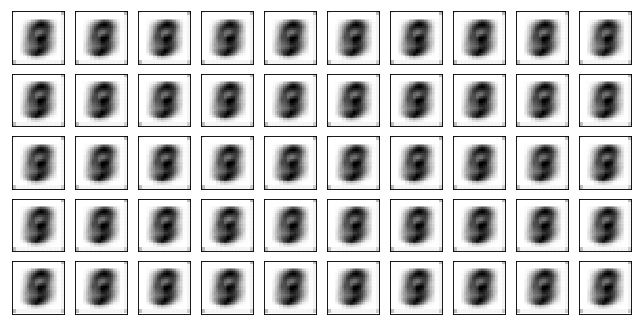

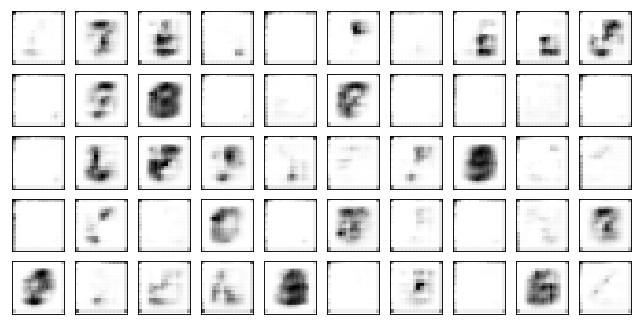

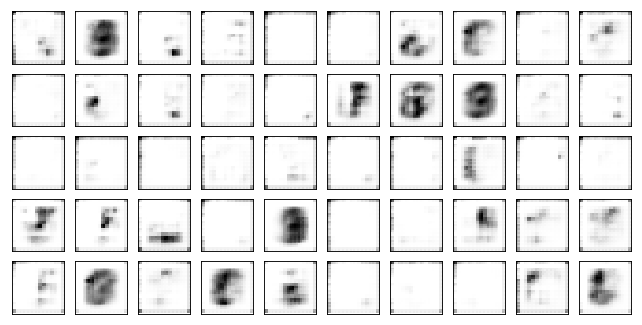

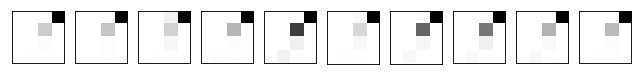

Model Adam Discr+bn+dp:


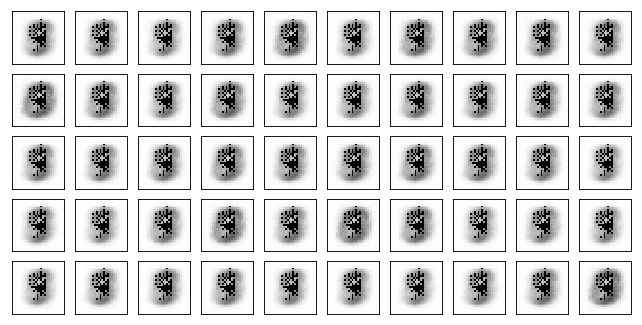

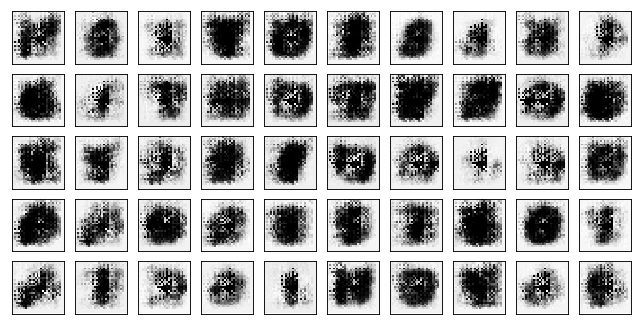

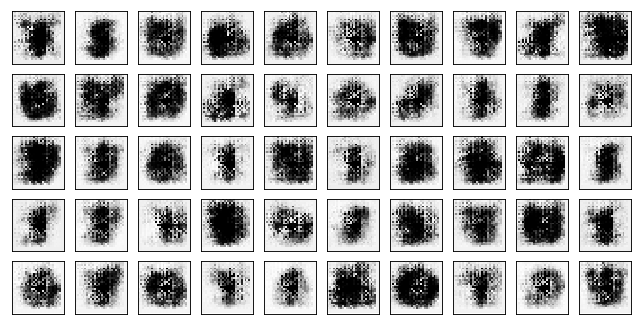

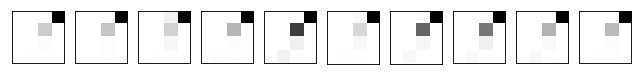

Test losses: 
Adam Discr: 1.34763503 / 38.74819565 / 0.00251961 
Adam Discr+bn+dp: 1.93964529 / 54.18350983 / 0.00180013 

Train Epoch: 8 [0/50000 (0%)]	Losses Adam Discr: AE:7.8655 D:0.0004 Adam Discr+bn+dp: AE:8.6070 D:0.0011
Train Epoch: 8 [10000/50000 (20%)]	Losses Adam Discr: AE:7.1394 D:0.0301 Adam Discr+bn+dp: AE:8.4095 D:0.0004
Train Epoch: 8 [20000/50000 (40%)]	Losses Adam Discr: AE:7.0556 D:0.0014 Adam Discr+bn+dp: AE:9.1400 D:0.0024
Train Epoch: 8 [30000/50000 (60%)]	Losses Adam Discr: AE:7.6234 D:0.0011 Adam Discr+bn+dp: AE:8.2879 D:0.0009
Train Epoch: 8 [40000/50000 (80%)]	Losses Adam Discr: AE:8.0148 D:0.0011 Adam Discr+bn+dp: AE:8.8225 D:0.0020
Train Epoch: 8 [50000/50000 (100%)]	Losses Adam Discr: AE:8.1543 D:0.0011 Adam Discr+bn+dp: AE:8.7268 D:0.0209
Model Adam Discr:


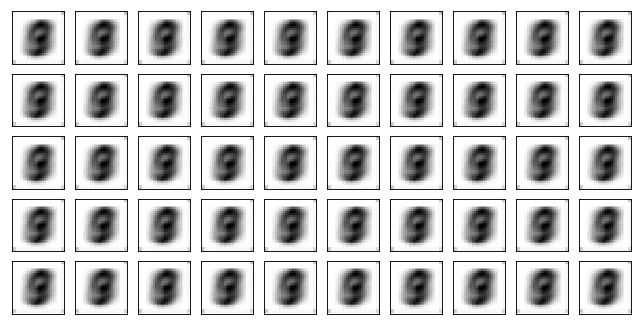

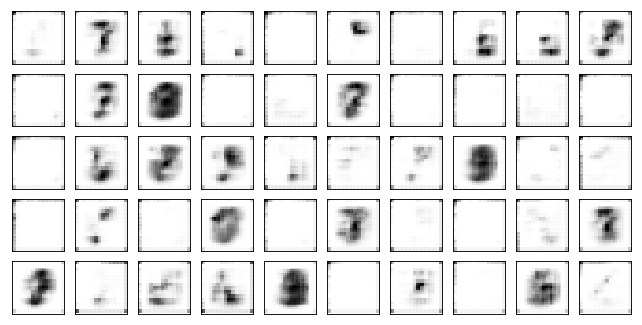

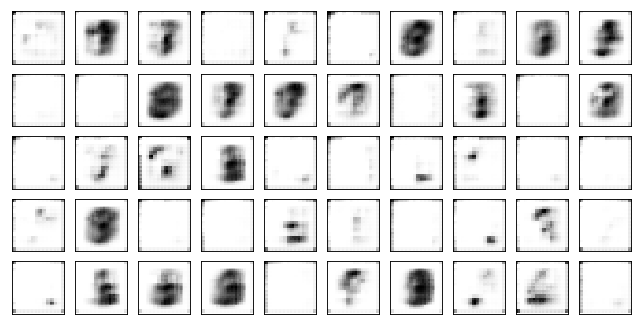

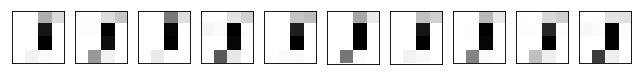

Model Adam Discr+bn+dp:


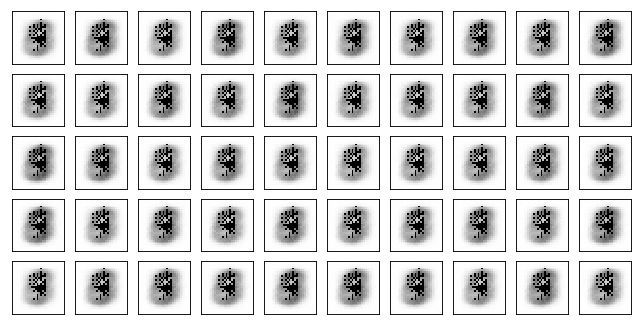

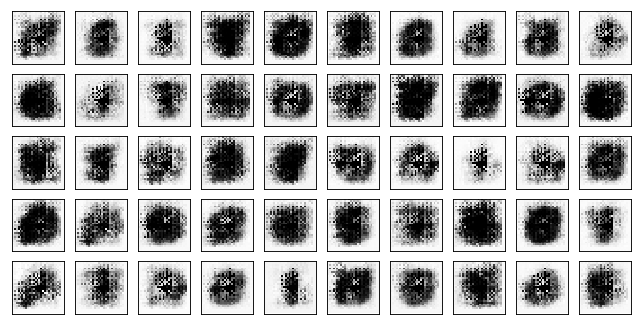

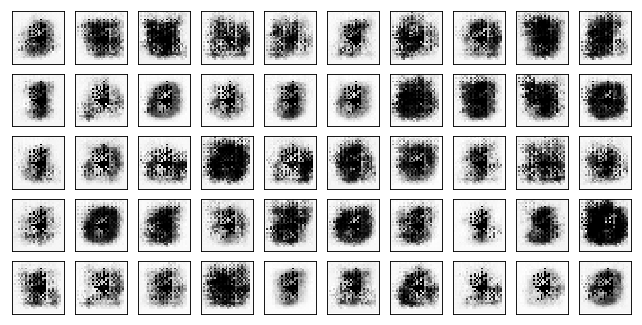

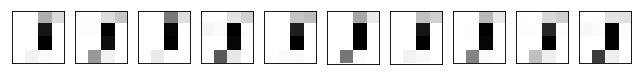

Test losses: 
Adam Discr: 1.34957278 / 39.49145889 / 0.00439510 
Adam Discr+bn+dp: 1.94398761 / 51.04468918 / 0.00604113 

Train Epoch: 9 [0/50000 (0%)]	Losses Adam Discr: AE:8.1421 D:0.0010 Adam Discr+bn+dp: AE:9.4324 D:0.0004
Train Epoch: 9 [10000/50000 (20%)]	Losses Adam Discr: AE:8.5528 D:0.0006 Adam Discr+bn+dp: AE:8.5453 D:0.0148
Train Epoch: 9 [20000/50000 (40%)]	Losses Adam Discr: AE:8.5429 D:0.0003 Adam Discr+bn+dp: AE:9.2008 D:0.0006
Train Epoch: 9 [30000/50000 (60%)]	Losses Adam Discr: AE:8.5258 D:0.0004 Adam Discr+bn+dp: AE:9.7949 D:0.0003
Train Epoch: 9 [40000/50000 (80%)]	Losses Adam Discr: AE:8.2909 D:0.0003 Adam Discr+bn+dp: AE:8.8857 D:0.0004
Train Epoch: 9 [50000/50000 (100%)]	Losses Adam Discr: AE:8.6846 D:0.0003 Adam Discr+bn+dp: AE:9.4389 D:0.0071
Model Adam Discr:


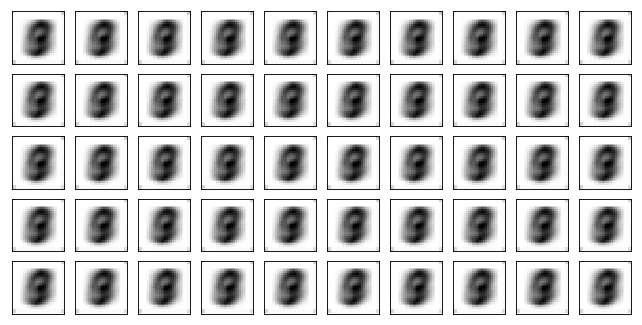

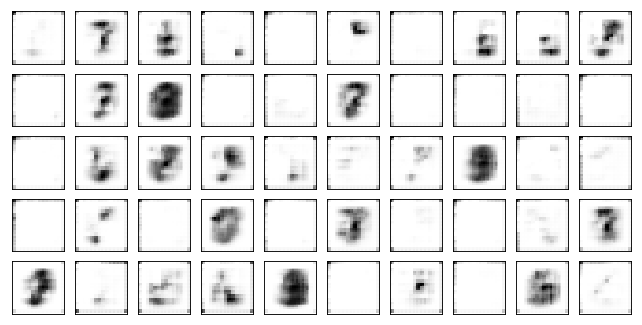

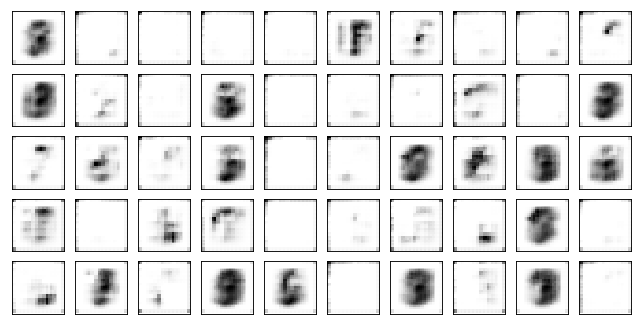

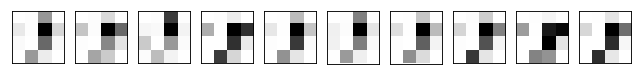

Model Adam Discr+bn+dp:


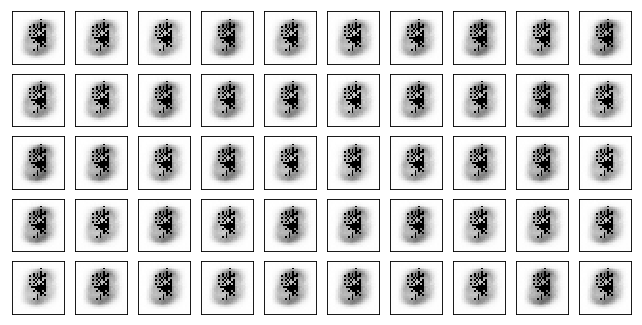

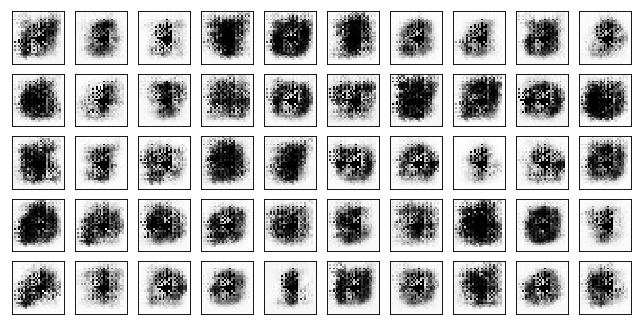

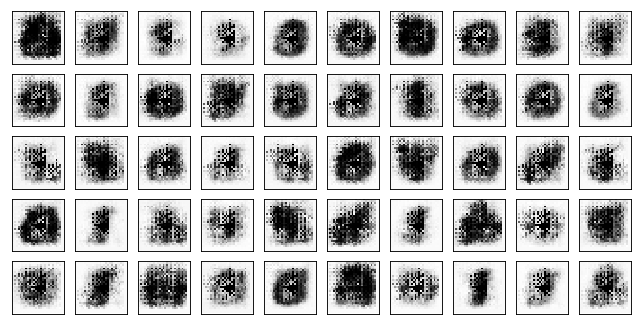

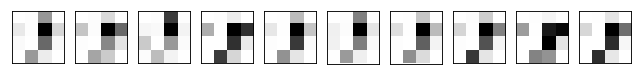

Test losses: 
Adam Discr: 1.34830976 / 44.45597839 / 0.00068884 
Adam Discr+bn+dp: 1.89156079 / 55.99718857 / 0.00197007 

Train Epoch: 10 [0/50000 (0%)]	Losses Adam Discr: AE:8.8771 D:0.0007 Adam Discr+bn+dp: AE:9.2492 D:0.0005
Train Epoch: 10 [10000/50000 (20%)]	Losses Adam Discr: AE:9.8195 D:0.0002 Adam Discr+bn+dp: AE:9.3608 D:0.0005
Train Epoch: 10 [20000/50000 (40%)]	Losses Adam Discr: AE:9.2362 D:0.0001 Adam Discr+bn+dp: AE:9.1590 D:0.0084
Train Epoch: 10 [30000/50000 (60%)]	Losses Adam Discr: AE:9.3139 D:0.0002 Adam Discr+bn+dp: AE:9.9830 D:0.0011
Train Epoch: 10 [40000/50000 (80%)]	Losses Adam Discr: AE:9.4419 D:0.0002 Adam Discr+bn+dp: AE:9.3562 D:0.0107
Train Epoch: 10 [50000/50000 (100%)]	Losses Adam Discr: AE:9.3490 D:0.0002 Adam Discr+bn+dp: AE:9.1308 D:0.0007
Model Adam Discr:


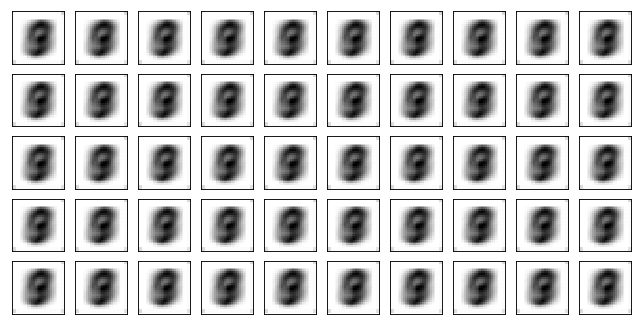

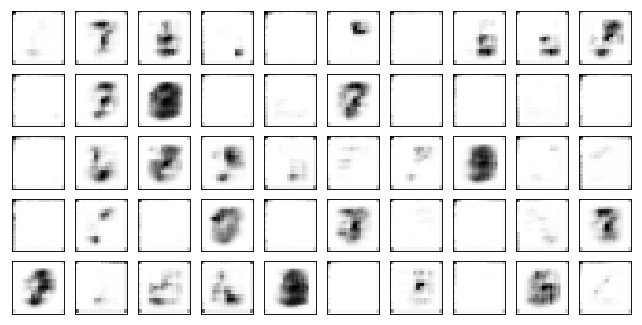

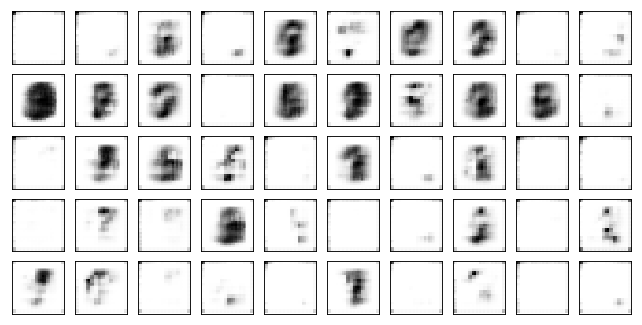

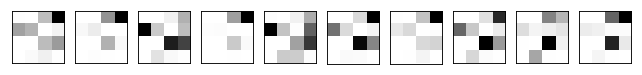

Model Adam Discr+bn+dp:


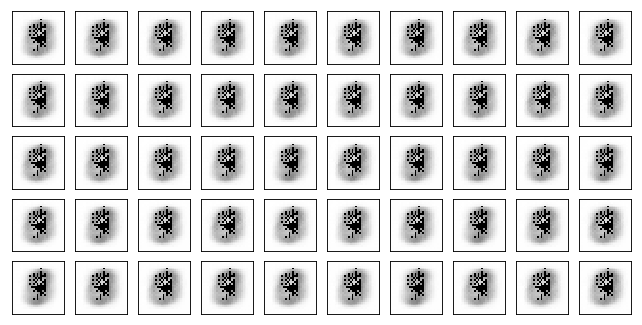

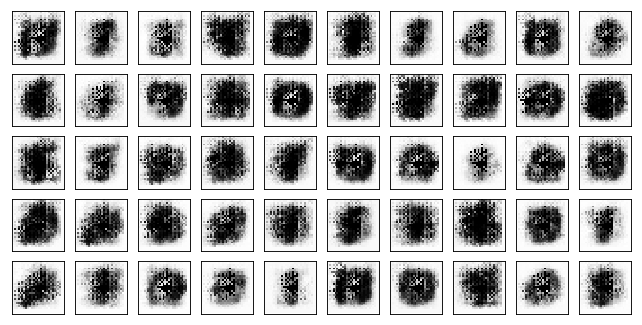

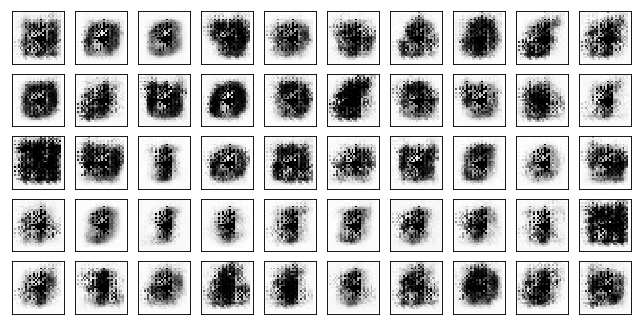

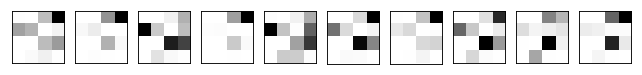

Test losses: 
Adam Discr: 1.34682620 / 47.54590988 / 0.00072178 
Adam Discr+bn+dp: 1.89143300 / 61.76463318 / 0.00637774 



In [15]:
for epoch in range(1, 11):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [16]:
torch.save(models['Adam Discr+bn+dp'], './adam_ds2')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't r

### Вывод результатов

In [17]:
model = torch.load('./adam_ds2')

In [18]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


enc= torch.Size([50, 16])


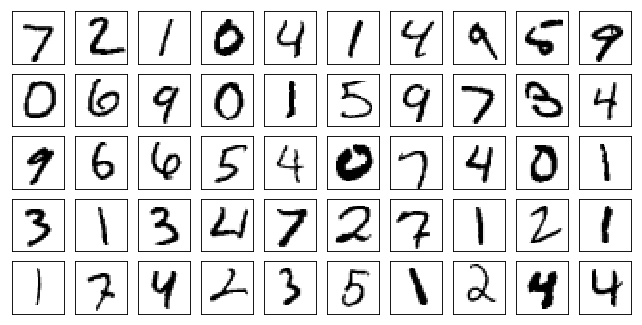

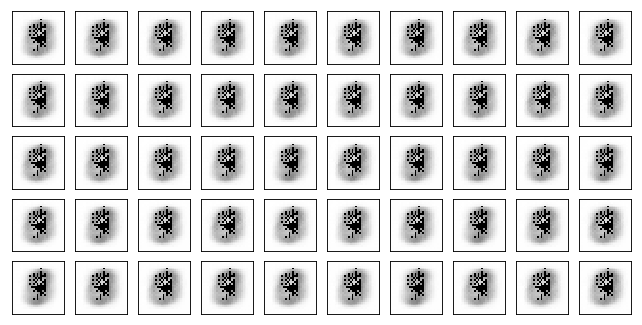

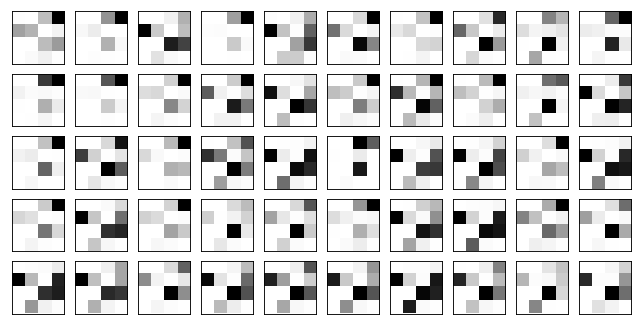

In [19]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [22]:
def show_generated_samples():
    pred_z = torch.randn((50, 16))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

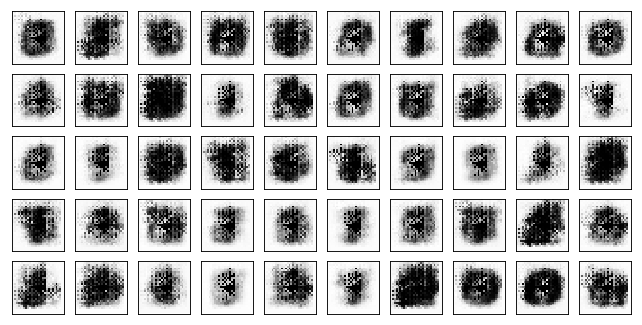

In [24]:
show_generated_samples()